In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from ksnunu_utils import * 

# Reinterpreting $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
binning = np.linspace(0.0, 19.25, 11) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 19.25, 20)

## Define the NP model in WC space

In [3]:
cvl = 5.0
cvr = 1.0
csl = 1.0
csr = 1.0
ctl = 1.0

## Generate some SM samples

In [4]:
SMsamples = int(1e6)

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=123))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [5]:
np.random.seed(456)
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

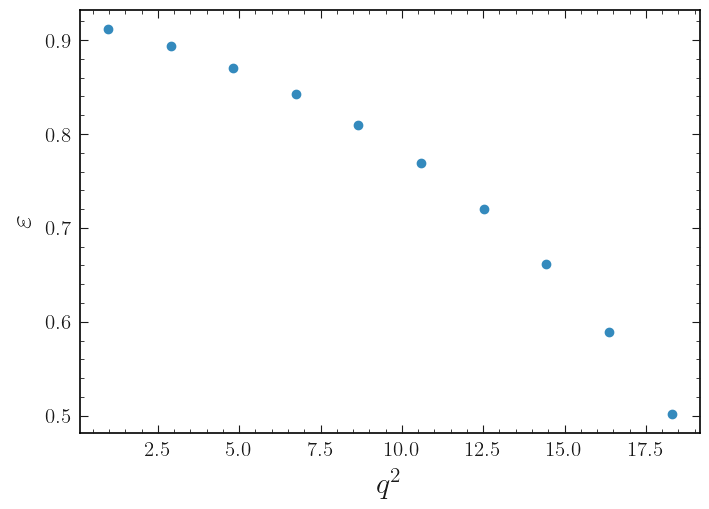

In [6]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

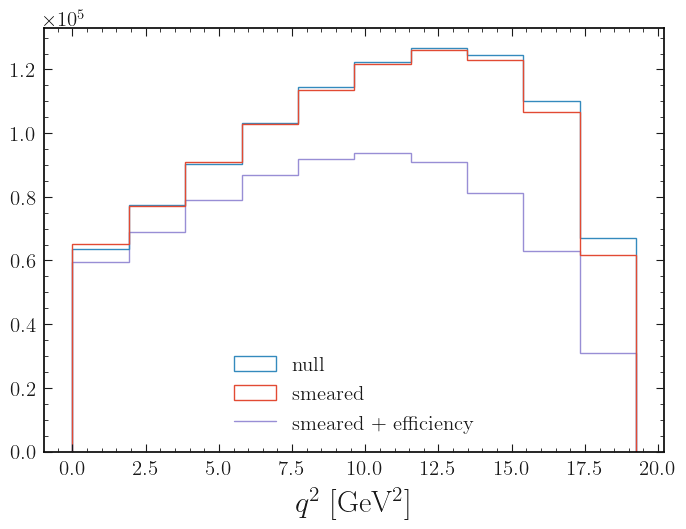

In [7]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [8]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=789))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [9]:
np.random.seed(101)
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

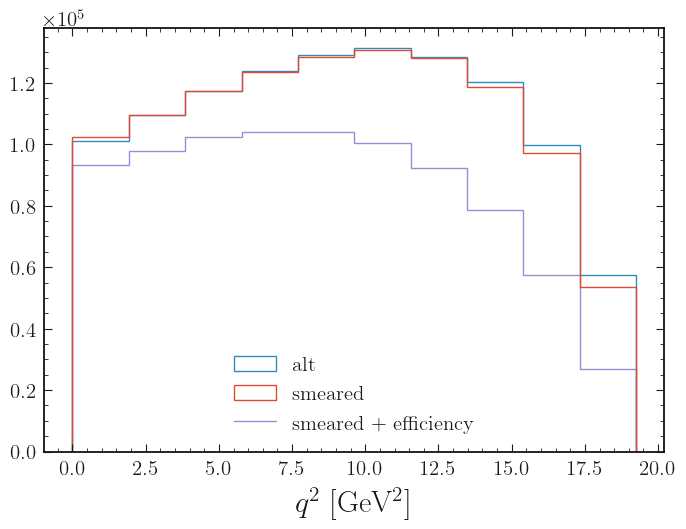

In [10]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Set up the mapping distribution

In [11]:
mapping_dist = np.histogramdd([null_samples.flatten(), null_samples_smeared.flatten()], bins=[binning, q2binning])[0]
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [12]:
null = null_pred()
alt = alt_pred()

In [13]:
ana  = analysis()

v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()
a01  = ana.parameters['B->K^*::alpha^A0_1@BSZ2015' ].evaluate() 
a02  = ana.parameters['B->K^*::alpha^A0_2@BSZ2015' ].evaluate() 
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate() 
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate() 
a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate() 
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate() 
t11  = ana.parameters['B->K^*::alpha^T1_1@BSZ2015' ].evaluate() 
t12  = ana.parameters['B->K^*::alpha^T1_2@BSZ2015' ].evaluate() 
t21  = ana.parameters['B->K^*::alpha^T2_1@BSZ2015' ].evaluate() 
t22  = ana.parameters['B->K^*::alpha^T2_2@BSZ2015' ].evaluate() 
t231 = ana.parameters['B->K^*::alpha^T23_1@BSZ2015'].evaluate() 
t232 = ana.parameters['B->K^*::alpha^T23_2@BSZ2015'].evaluate()

In [14]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.026709,-0.008171,-0.006106,-0.211000,-0.005672,-0.080119,-0.025883,-0.226553,0.001992,-0.000442,0.009041,0.058839,-0.009825,-0.085994
1,-0.008171,2.374789,-0.023708,1.442716,-0.042291,0.203770,-0.166514,-0.760009,-0.002924,-0.074359,-0.083942,-0.628703,-0.024142,-0.320101
2,-0.006106,-0.023708,0.076261,0.702227,0.034303,0.232802,0.128492,0.940198,0.001037,0.103982,-0.022786,-0.143389,0.009350,0.121815
3,-0.211000,1.442716,0.702227,11.697822,0.434719,3.891191,1.618649,12.829478,-0.014559,0.908324,-0.405312,-2.693621,0.222004,2.193235
4,-0.005672,-0.042291,0.034303,0.434719,0.037044,0.252488,0.102107,0.753825,-0.001144,0.016086,-0.013513,-0.089986,0.036618,0.304747
5,-0.080119,0.203770,0.232802,3.891191,0.252488,2.074463,0.704635,5.460211,-0.019887,-0.045196,-0.130239,-0.901239,0.289731,2.335484
6,-0.025883,-0.166514,0.128492,1.618649,0.102107,0.704635,0.415966,3.061814,0.002756,0.319588,-0.059201,-0.351671,0.070023,0.712980
7,-0.226553,-0.760009,0.940198,12.829478,0.753825,5.460211,3.061814,22.937072,0.012242,2.298207,-0.472153,-2.848996,0.531943,5.363353
8,0.001992,-0.002924,0.001037,-0.014559,-0.001144,-0.019887,0.002756,0.012242,0.019838,0.126582,0.004681,0.021776,-0.006702,-0.075416
9,-0.000442,-0.074359,0.103982,0.908324,0.016086,-0.045196,0.319588,2.298207,0.126582,3.277529,-0.064812,0.105328,-0.312729,-1.177074


In [15]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,), 'bounds': ((0.01, 3*cvl),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.01, ), 'bounds': ((0.01, 3*cvr),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.01, ), 'bounds': ((0.01, 3*csl),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.01, ), 'bounds': ((0.01, 3*csr),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.01, ), 'bounds': ((0.01, 3*ctl),), 'paramset_type': 'unconstrained'},
                'FFKs'    :{'inits': (v1, v2, a01, a02, a11, a12, a121, a122, t11, t12, t21, t22, t231, t232), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

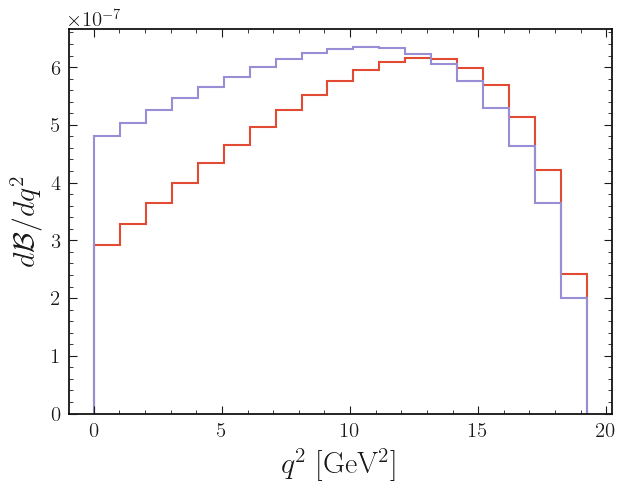

In [16]:
pars = (cvl, cvr, csl, csr, ctl, v1, v2, a01, a02, a11, a12, a121, a122, t11, t12, t21, t22, t231, t232)
lims = [0.0, 19.25]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

(<Figure size 800x550 with 2 Axes>,
 <Axes: xlabel='Kinematic bins', ylabel='Fitting bins'>)

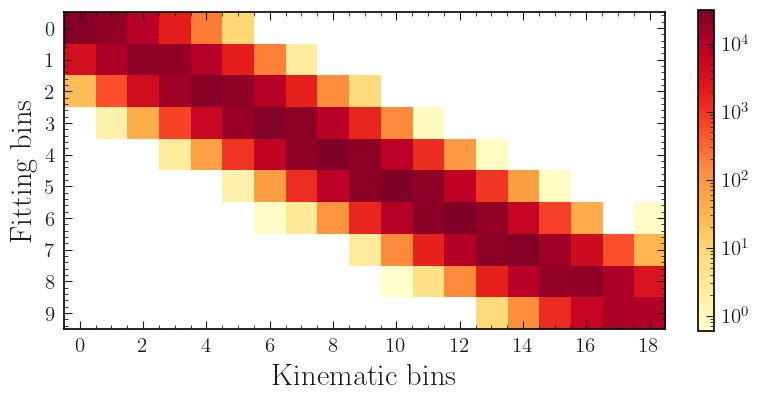

In [17]:
plot.map(cmod, cmap='YlOrRd', norm=LogNorm())

## Set up the model

In [18]:
spec = {
  "channels": [
    {
      "name": "B->K*nunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "ksnunu_theory",
                "type": "ksnunu",
                "data":
                    {"expr": "ksnunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->K*nunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->K*nunu',
   'samples': [{'name': 'signal',
     'data': [59578.29014812324,
      68935.99056330061,
      79108.83218028645,
      86759.86547799589,
      91954.93775364327,
      93731.10834287161,
      90786.30478920923,
      81263.39749493824,
      62907.90053680823,
      30966.970680659895],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [244.08664475575725,
        262.5566425807974,
        281.2629235791423,
        294.5502766557789,
        303.24072575042305,
        306.1553663466829,
        301.30765803279746,
        285.06735606683947,
        250.81447433672608,
        175.97434665501643]},
      {'name': 'ksnunu_theory',
       'type': 'ksnunu',
       'data': {'expr': 'ksnunu_weight_fn'}}]}]}]}

## Save and load model

In [19]:
modifier.save('ksnunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('ksnunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [20]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
# fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


/opt/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


W MnPosDef Matrix forced pos-def by adding to diagonal 0.152618
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0140329
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0132107
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0162739


{'cvl': array([4.03841673, 0.05400132]),
 'cvr': array([0.30586871, 0.07601743]),
 'csl': array([2.45768572, 0.13853838]),
 'csr': array([0.01, 0.  ]),
 'ctl': array([1.02341581, 0.0053619 ]),
 'FFKs_decorrelated[0]': array([0.06683236, 0.30054998]),
 'FFKs_decorrelated[1]': array([0.18146744, 0.58226624]),
 'FFKs_decorrelated[2]': array([-0.08164832,  0.536261  ]),
 'FFKs_decorrelated[3]': array([-0.19630555,  0.3956365 ]),
 'FFKs_decorrelated[4]': array([0.0136653 , 0.86040013]),
 'FFKs_decorrelated[5]': array([-0.03458888,  0.7433598 ]),
 'FFKs_decorrelated[6]': array([-0.02162791,  0.94880211]),
 'FFKs_decorrelated[7]': array([0.12734174, 0.3327262 ]),
 'FFKs_decorrelated[8]': array([-0.06680717,  0.78155571]),
 'FFKs_decorrelated[9]': array([-0.01394298,  0.98519108]),
 'FFKs_decorrelated[10]': array([-0.02247098,  0.75821651]),
 'FFKs_decorrelated[11]': array([0.01801364, 0.73906793]),
 'FFKs_decorrelated[12]': array([0.0165608 , 0.74844322]),
 'FFKs_decorrelated[13]': array([-0.

In [21]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 4.038416733497432,
 'cvr': 0.3058687109087077,
 'csl': 2.457685723310836,
 'csr': 0.01,
 'ctl': 1.023415806219743,
 'FFKs[0]': -1.1049938726994646,
 'FFKs[1]': 2.721293194309536,
 'FFKs[2]': -1.1442996630177988,
 'FFKs[3]': 2.987245911863083,
 'FFKs[4]': 0.4469812359941129,
 'FFKs[5]': 1.1555184575206836,
 'FFKs[6]': 0.5433095436608568,
 'FFKs[7]': 0.87038337743893,
 'FFKs[8]': -0.9382951936192102,
 'FFKs[9]': 2.521484102495719,
 'FFKs[10]': 0.5896508688140301,
 'FFKs[11]': 1.6936048465529348,
 'FFKs[12]': 0.9102724789100493,
 'FFKs[13]': 2.190134047043134,
 'mu': 1.0,
 'stat': [1.0016948324837966,
  0.998261086181451,
  0.9999343543644348,
  0.9991201666167765,
  1.0006725249092123,
  1.0013765724985428,
  0.9992083069330093,
  0.9993258670358037,
  1.000787600578724,
  0.9995100820712534]}

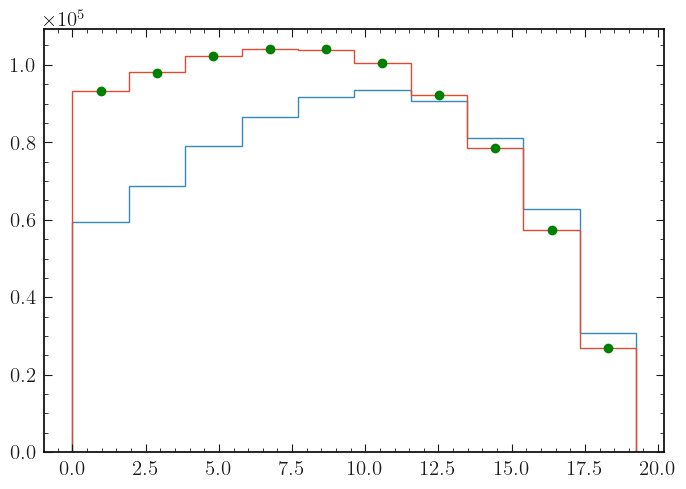

In [22]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')